<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/lessons/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idősorok előrebecslése mély tanulással

Mottó: a jóslás nehéz műfaj, főleg a jövőre vonatkozó

## Adatok előkészítése

A KSH oldaláról letölthető, 2015 napjainkig tartó halálozási adatokat fogjuk használni. Az adatok heti bontásban és több korcsoportra állnak rendelkezésre. Mi csak a heti összesítést fogjuk használni, egyváltozós adatsorként.

Az adatokat egy pandas adatkeretbe töltjük be.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import zeros, mean, array
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, Conv1DTranspose, MaxPooling1D, LSTM, InputLayer, Input, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# adatok letöltése
!wget -q https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/machine_learning/lessons/data/weekly_death.csv
df = pd.read_csv('weekly_death.csv', parse_dates=['start', 'end'])
df[['start', 'end', 'all_total']].head()

,start,end,all_total
0,2014-12-29,2015-01-04,2800
1,2015-01-05,2015-01-11,3005
2,2015-01-12,2015-01-18,2900
3,2015-01-19,2015-01-25,3005
4,2015-01-26,2015-02-01,3067


Nézzük meg az adatok időbeli változásátt!

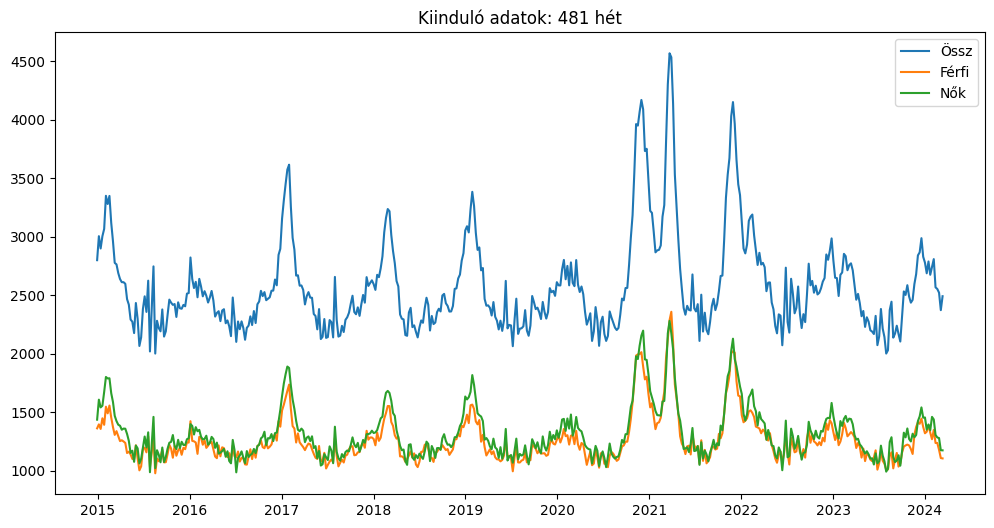

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df['start'], df['all_total'], label='Össz')
plt.plot(df['start'], df['man_total'], label='Férfi')
plt.plot(df['start'], df['woman_total'], label='Nők')
plt.legend()
_ = plt.title(f'Kiinduló adatok: {df.shape[0]} hét')

Kialakítjuk a rövid, *n_steps* hosszúságú adatsorokat a modellek tanításához. Próbálja ki nagyobb hosszúságú adatsorokkal is a modelleket.

In [ ]:
def split_sequence(seq, n_steps):
    """ change unvariate time serie into n_steps samples
        seq: univaiate time serie (a pandas serie, list)
        n_steps: length of samples
        returns: X, y (numpy arrays)
    """
    sequence = seq.to_numpy()
    n = sequence.shape[0]
    X = zeros((n - n_steps, n_steps))
    y = sequence[n_steps:]
    X = np.array([sequence[i:i+n_steps] for i in range(0, n-n_steps)])
    return X, y

In [ ]:
def prepare(seq, n_steps, n_features, test_rate=0.1):
    """ prepare univariate data and split into train and test parts
        seq: univaiate time serie (a pandas serie, list)
        n_steps: length of samples
        test_rate: rate of test data
        returns X_train, y_train, X_test, y_test
    """
    # split into samples
    X, y = split_sequence(seq, n_steps)
    #n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # split train and test data
    n_test = int(test_rate * y.shape[0])
    X_train = X[:-n_test]
    y_train = y[:-n_test]
    X_test = X[-n_test:]
    y_test = y[-n_test:]
    return X_train, y_train, X_test, y_test

In [ ]:
# define input sequence
raw_seq = df['all_total']
# choose a number of time steps
n_steps = 7
EPOCHS = 1000
n_features = 1
test_rate = 0.05
X_train, y_train, X_test, y_test = prepare(raw_seq, n_steps, n_features, test_rate)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((451, 7, 1), (451,), (23, 7, 1), (23,))

## 1D konvolúciós neurális hálózat

Egy autoregresszív módszert használunk az adatok rövidtávú előrebecsléséhez.

In [ ]:
# modell definíció
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
print(model.summary())
# modell tanítása
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 29, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 896)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │          44,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,093 (176.14 KB)

 Trainable params: 45,093 (176.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Hasonlítsuk össze az ismert értékeket a modellből becsült adatokkal.

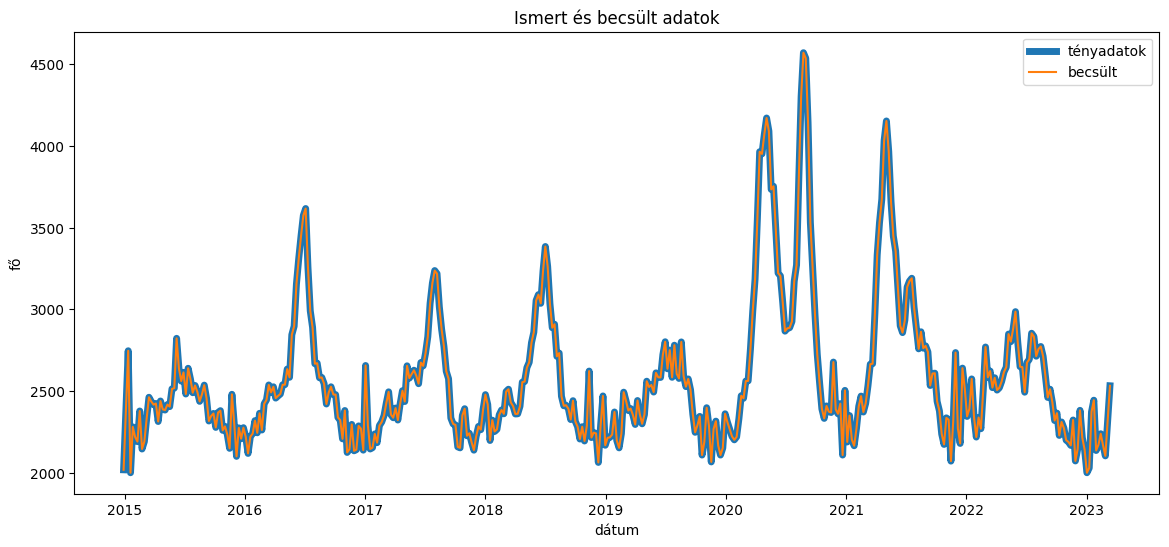

In [ ]:
# predict values from model
train_size = y_train.shape[0]
y_pred = model.predict(X_train, verbose=0)
plt.figure(figsize=(14,6))
plt.xlabel("dátum")
plt.ylabel("fő")
plt.plot(df["start"][:train_size], y_train, linewidth=5.0, label='tényadatok')
plt.plot(df["start"][:train_size], y_train, label='becsült')   # TODO one week shift!
plt.legend()
_ = plt.title('Ismert és becsült adatok')

Becslés a teszt adatokra.

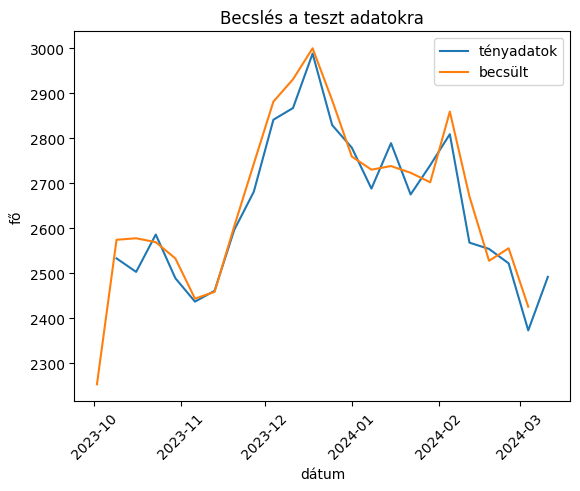

In [ ]:
# make estimation for 2024 data
y_test_pred = model.predict(X_test, verbose=0)
test_size = y_test.shape[0]
offset = int(n_steps / 2)
plt.xlabel("dátum")
plt.ylabel("fő")
plt.plot(df['start'][-y_test.shape[0]:], y_test, label='tényadatok')
plt.plot(df['start'][-y_test.shape[0]-offset:-offset], y_test_pred[-y_test.shape[0]:], label='becsült')
plt.xticks(rotation=45)
plt.legend()
_ = plt.title('Becslés a teszt adatokra')

Néhány statisztikai adat a modell becsléséről.

In [ ]:
# mean absolute percentage error MAPE
print(f"MAPE train: {mean_absolute_percentage_error(y_train, y_pred):5.1%}")
print(f"MAPE  test: {mean_absolute_percentage_error(y_test, y_test_pred):5.1%}")
# root mean square error
print(f"RMS  train: {mean_squared_error(y_train, y_pred)**0.5:.1f}")
print(f"RMS   test: {mean_squared_error(y_test, y_test_pred)**0.5:.1f}")

MAPE train:  4.8%
MAPE  test:  3.6%
RMS  train: 165.4
RMS   test: 121.2


Becsüljük egy következő értéket.

In [ ]:
X_new = X_test[-1]
X_new = X_new.reshape(1, n_steps, 1)
y_new_pred = model.predict(X_new, verbose=0)
print(f"Becslés 2024.03.18-25 hétre: {int(y_new_pred[0, 0])}")

Becslés 2024.03.18-25 hétre: 2425


## Recurrent Neural Network (RNN)

Az RNN Long Short-Term Memory (LSTM) típusú neurális hálózatot használ.

In [ ]:
inputs = Input(shape=(n_steps, n_features))
lstm = LSTM(50, activation="relu")(inputs)
outputs = Dense(1)(lstm)

lstm_model = Model(inputs, outputs)
lstm_model.compile(optimizer='adam', loss='mse')
print(lstm_model.summary())

lstm_hist =lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, verbose=0)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 3, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None


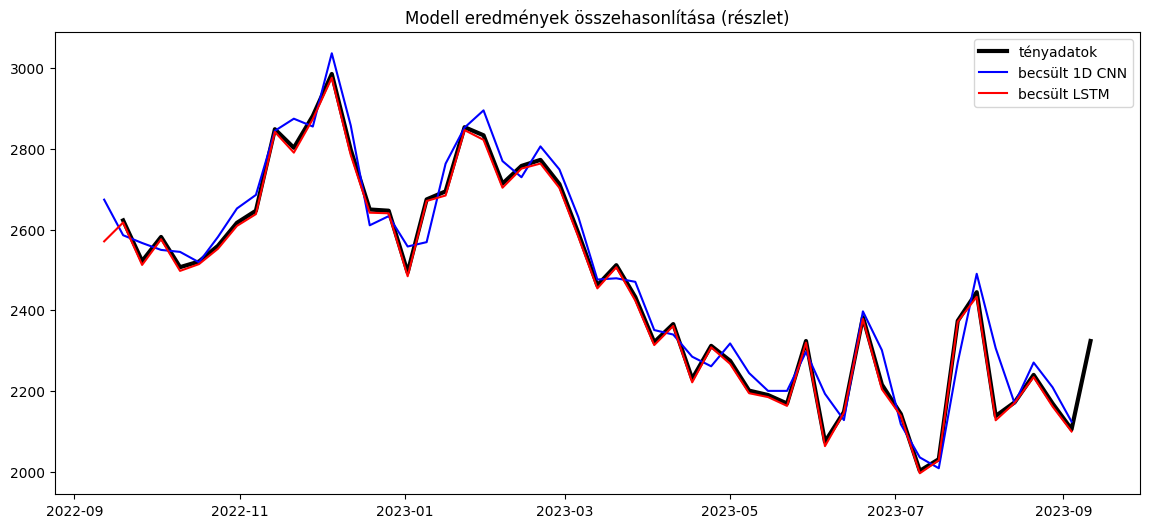

In [ ]:
# predict values from model
y_lstm_pred = lstm_model.predict(X_train, verbose=0)
plt.figure(figsize=(14,6))
plt.plot(df["start"][train_size-52:train_size], y_train[-52:], c='black', linewidth=3.0, label='tényadatok')
plt.plot(df["start"][train_size-52-offset:train_size-offset], y_pred[-52:], c='blue', label='becsült 1D CNN')
plt.plot(df["start"][train_size-52-offset:train_size-offset], y_lstm_pred[-52:], c='red', label='becsült LSTM')
plt.legend()
_ = plt.title('Modell eredmények összehasonlítása (részlet)')

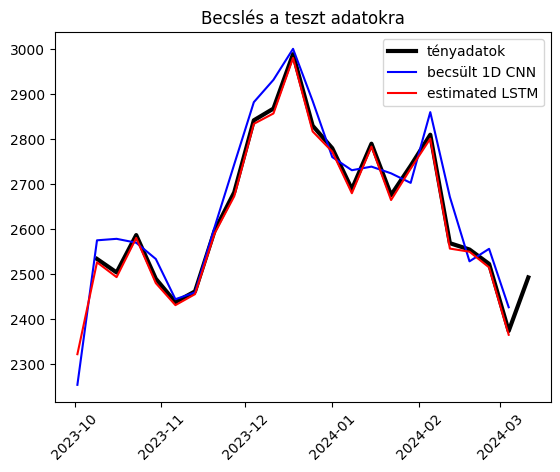

In [ ]:
y_lstm_test_pred = lstm_model.predict(X_test, verbose=0)
plt.plot(df['start'][-test_size:], y_test, c='black', linewidth=3.0, label='tényadatok')
plt.plot(df['start'][-test_size-offset:-offset], y_test_pred, c='blue', label='becsült 1D CNN')
plt.plot(df['start'][-test_size-offset:-offset], y_lstm_test_pred, c='red', label='estimated LSTM')
plt.xticks(rotation=45)
plt.legend()
_ = plt.title('Becslés a teszt adatokra')

In [ ]:
print("            CNN      RNN")
print(f"MAPE train: {mean_absolute_percentage_error(y_train, y_pred):6.1%}", end="")
print(f"    {mean_absolute_percentage_error(y_train, y_lstm_pred):6.1%}")
print(f"MAPE  test: {mean_absolute_percentage_error(y_test, y_test_pred):6.1%}", end="")
print(f"    {mean_absolute_percentage_error(y_test, y_lstm_test_pred):6.1%}")
# root mean square error
print(f"RMS  train: {mean_squared_error(y_train, y_pred)**0.5:5.1f}", end="")
print(f"     {mean_squared_error(y_train, y_lstm_pred)**0.5:5.1f}")
print(f"RMS   test: {mean_squared_error(y_test, y_test_pred)**0.5:5.1f}", end="")
print(f"     {mean_squared_error(y_test, y_lstm_test_pred)**0.5:5.1f}")

            CNN      RNN
MAPE train:   4.8%      4.6%
MAPE  test:   3.6%      3.7%
RMS  train: 165.4     161.6
RMS   test: 121.2     113.7


In [ ]:
# predict for future
X_new_cnn = X_test[-1]
X_new_rnn = X_test[-1]
n_future = 5
print(f"Becslés CNN  RNN")
for i in range(n_future):
    y_new_cnn = model.predict(X_new_cnn.reshape(1, n_steps, n_features), verbose=0)
    y_new_rnn = lstm_model.predict(X_new_rnn.reshape(1, n_steps, n_features), verbose=0)
    print(f"{i+1:3}    {int(y_new_cnn[0, 0])} {int(y_new_rnn[0, 0])}")
    X_new_cnn = np.roll(X_new_cnn, -1)
    X_new_cnn[-1] = y_new_cnn[0, 0]
    X_new_rnn = np.roll(X_new_rnn, -1)
    X_new_rnn[-1] = y_new_rnn[0, 0]


Becslés CNN  RNN
  1    2425 2364
  2    2387 2359
  3    2422 2352
  4    2417 2345
  5    2447 2338


# Kilógó értékek (durva hibák) keresése az idősorban

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

In [ ]:
model = Sequential([Input(shape=(X_train.shape[1], X_train.shape[2])),
                   Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
                   Dropout(rate=0.2),
                   Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
                   Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
                   Dropout(rate=0.2),
                   Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
                   Conv1DTranspose(filters=1, kernel_size=7, padding="same")
                   ])
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 4, 32)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 2, 16)               │           3,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_12                  │ (None, 4, 16)               │           1,808 │
│ (Conv1DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 4, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_13                  │ (None, 8, 32)               │           3,616 │
│ (Conv1DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_14                  │ (None, 8, 1)                │             225 │
│ (Conv1DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, mode="min")])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 773ms/step - loss: 6800169.5000 - val_loss: 5818637.0000
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6360921.5000 - val_loss: 5305167.5000
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5782391.5000 - val_loss: 4400085.5000
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4710853.5000 - val_loss: 2889559.2500
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2922894.0000 - val_loss: 1072798.3750
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1193971.1250 - val_loss: 850539.5000
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1546118.6250 - val_loss: 778193.5625
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1251992.5000 - val_loss: 338193.9688
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 696065.5000 - val_loss: 457833.4062
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 774546.4375 - val_loss: 408169.9062
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - los

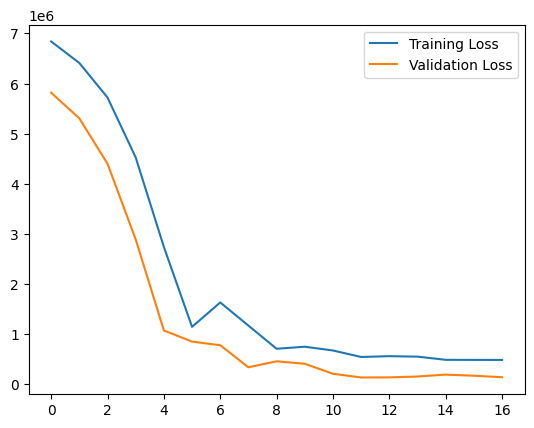

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Tanító adatok rekonstrukciója

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
(451, 7, 1) (451, 7, 1)
Reconstruction error threshold:  666.77001953125


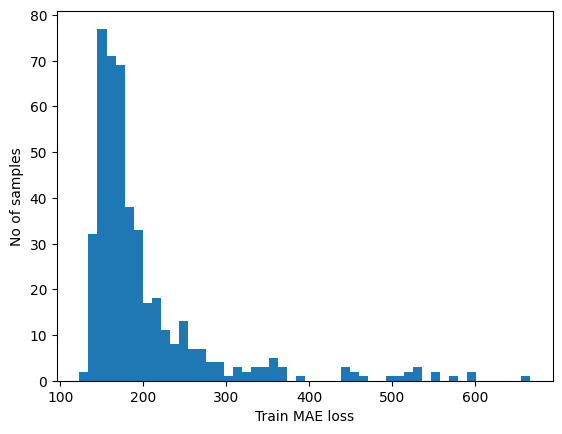

In [ ]:
# Get train MAE loss.
X_train_pred = model.predict(X_train)[:X_train.shape[0], :X_train.shape[1], :X_train.shape[2]]

print(X_train_pred.shape, X_train.shape)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

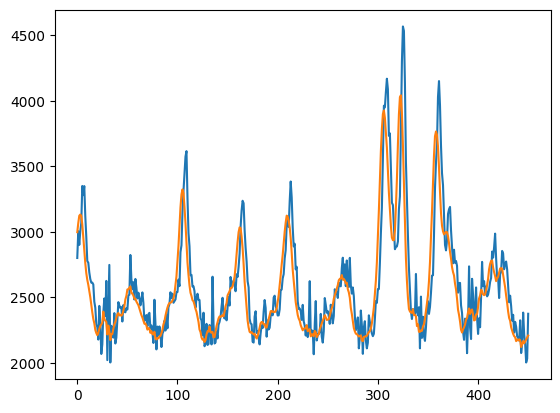

In [ ]:
# Checking how the first sequence is learnt
plt.plot(X_train[:,0,0])
plt.plot(X_train_pred[:,0,0])

Teszt adatok

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Text(0, 0.5, 'No of samples')

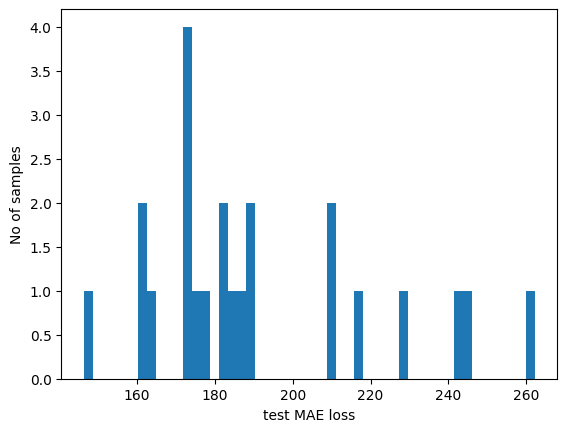

In [ ]:
X_test_pred = model.predict(X_test)[:X_test.shape[0], :X_test.shape[1], :X_test.shape[2]]

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")

In [ ]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)


In [ ]:
# data i is an anomaly if samples [(i - n_steps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(n_steps - 1, X_train.shape[0] - n_steps + 1):
    if np.all(anomalies[data_idx - n_steps + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [ ]:
anomalies


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])